# Exploration du jeu de données TEST

## Packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Chargement des données

In [2]:
files = ['USAGERS', 'VEHICULES', 'CARACTERISTIQUES', 'LIEUX',]
data_path = 'Data/TEST/TEST/'

test_data = pd.DataFrame()

for file_name in files: 
    path_to_file = data_path + file_name + '.csv'
    
    data = pd.read_csv(path_to_file, encoding="latin1", sep=",", low_memory=False)
    
    if file_name == 'USAGERS':
        test_data = pd.concat([test_data, data], axis=1)
    else:
        if file_name == 'VEHICULES':
            test_data = pd.merge(test_data, data, on=['Num_Acc', 'num_veh'], how='left')
        else:
            test_data = pd.merge(test_data, data, on=['Num_Acc'], how='left')
            
train_data = pd.read_csv('Filtered_Data/TRAIN/Full_Train_Data_V0_to_V4.csv', sep=',', low_memory=False)

# Fonctions utiles

In [3]:
def delete_columns(list_col: list[str], data_frame: pd.DataFrame) -> None:
    """
    Delete the selected columns from the data frame
    :param list_col: list of columns in the dataframe to delete
    :param data_frame: dataframe where the deletion is applied
    """
    for col in list_col:
        if col in data_frame.columns:
            data_frame.drop(labels=[col], axis=1, inplace=True)
            
def process_secu(value: int) -> int:
    """
    Process the conversion from a 2 digits integer to 1 digits integer
    :param value: to be converted
    :return: only the digit associated with the security element (or 8 if nothing used)
    """
    value_str = str(value)
    if len(value_str) >= 2 and value_str[1] == '1':
        return int(value_str[0])
    else:
        return pd.NA
    
def convert_to_int(time_str: str) -> int:
    """
    Convert the string time in an integer value to allow intervals implementation
    :param time_str: 'XX:XX', 'X:XX', 'XXX', 'X', X, XXX, ...
    :return: an integer of the time according to the time format XX(hours)XX(minutes)
    """
    if isinstance(time_str, str):
        if ':' in time_str:
            hours, minutes = map(int, time_str.split(':'))
            return hours * 100 + minutes
        else:
            return int(time_str)
    else:
        return time_str
    
def generate_intervals(start, end, step) -> list[int]:
    """
    Generate the intervals from the start to the end value by step
    :param start: first value in the interval
    :param end: last value in the interval
    :param step: range between two categories
    :return: list of intervals
    """
    list_cat = []
    for i in range(start, end, step):
        list_cat.append((i, i + step))
    return list_cat

def map_to_simple_value(value: int, list_cat: list[int]) -> int:
    """
    Function to map values to simple values based on intervals
    :param list_cat: list of the intervals
    :param value: value to map
    :return: mapped value
    """
    for i, interval in enumerate(list_cat):
        if interval[0] <= value < interval[1]:
            return simple_values[i]
    return None  

def clean_dep(dep: str) -> str:
    """
    Format the string of the department
    :param dep: French department
    :return: formatted string of the department
    """
    dep = str(dep)
    dep = dep.lstrip('0')
    if len(dep) == 3 and dep.endswith('0'):
        dep = dep[:-1]
    if dep in {'201', '202'}:
        dep = {'201': '2A', '202': '2B'}[dep]
    return dep
    
def convert_float_to_int(data_frame: pd.DataFrame, col_name: str) -> None:
    """
    Convert the column type in the related dataframe from float to int
    :param data_frame: dataframe where the column must be
    :param col_name: column to parse
    """
    data_frame[col_name] = data_frame[col_name].astype(int)
    
def get_info(data_frame: pd.DataFrame) -> dict:
    col_info = {}
    
    for col in data_frame.columns:
        possible_values = data_frame[col].unique()
        na_count = data_frame[col].isna().sum()
        obs_count = data_frame.shape[0]
        rep_na = na_count / obs_count * 100
        
        col_info[col] = {
            'possible_values': possible_values.tolist(),
            'na_count': na_count,
            'rep_na': rep_na
        }
        
    return col_info

def display_info(data_frame_test: pd.DataFrame, data_frame_train: pd.DataFrame) -> None:
    dict_info_test = get_info(data_frame_test)
    dict_info_train = get_info(data_frame_train)
    
    sorted_info_test = sorted(dict_info_test.items(), key=lambda x: x[1]['rep_na'], reverse=True)
    sorted_info_train = sorted(dict_info_train.items(), key=lambda x: x[1]['rep_na'], reverse=True)       
    
    for col, info in sorted_info_test:
        if info['rep_na'] >= 5:
            train_info = next((train_info for train_col, train_info in sorted_info_train if train_col == col), None)
            print('*******')
            print('TEST')
            print(f"- {col}: {info['rep_na']:.2f}%.")
            print('TRAIN')
            print(f"- {col}: {train_info['rep_na']:.2f}%.")
            print('')
        
def process_data_and_plot(data: pd.DataFrame) -> None:
    data['Four_Digits'] = data['Num_Acc'].astype(str).str[:4]
    four_digits_counts = data['Four_Digits'].value_counts()

    plt.figure(figsize=(14, 3))
    four_digits_counts.plot(kind='bar')
    plt.title('Distribution of Four-Digit Values in Num_Acc Column')
    plt.xlabel('Four-Digit Value')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    years = data['Four_Digits'].unique()
    full_data_years = {}  

    for year in years:
        full_data_years[year] = data[data['Four_Digits'] == year].copy()
        globals()[f"{data.name}_{year}"] = full_data_years[year].copy() 
    
    # Create dataframes for the intervals 2012-2018 and 2019-2022
    globals()[f"{data.name}_2012_2018"] = pd.concat([data for year, data in full_data_years.items() if 2012 <= int(year) <= 2018])
    globals()[f"{data.name}_2019_2022"] = pd.concat([data for year, data in full_data_years.items() if 2019 <= int(year) <= 2022])

    num_observations = sorted([(year, len(data)) for year, data in full_data_years.items()])
    years = [year for year, _ in num_observations]
    observations = [obs for _, obs in num_observations]

    plt.figure(figsize=(15, 5))
    plt.bar(years, observations, color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Number of Observations')
    plt.title('Number of Observations per Year')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    combined_years = ['2012-2018', '2019-2022']
    combined_counts = [sum(observations[:7]), sum(observations[7:])]

    plt.figure(figsize=(12, 6))
    plt.bar(years, observations, color='skyblue', label='Individual Years')
    plt.bar(combined_years, combined_counts, color='salmon', label='Combined Years')

    plt.xlabel('Year')
    plt.ylabel('Number of Observations')
    plt.title('Number of Observations per Year')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Répartition 2012 à 2022 sur le TEST Set

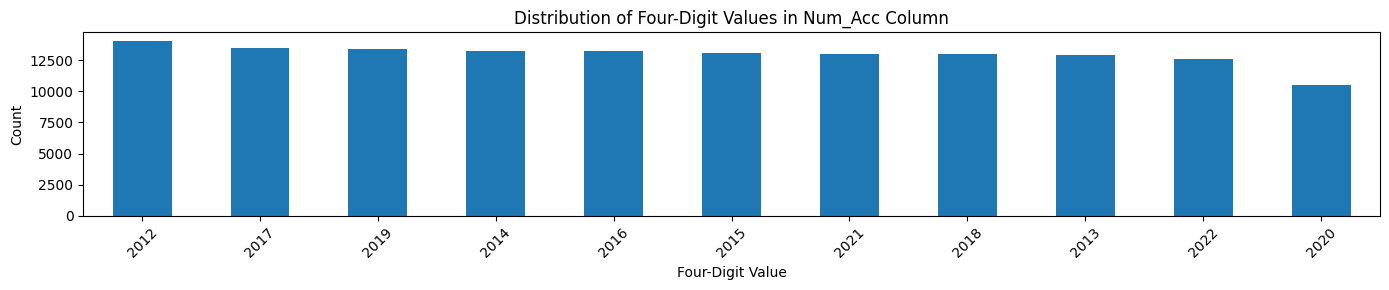

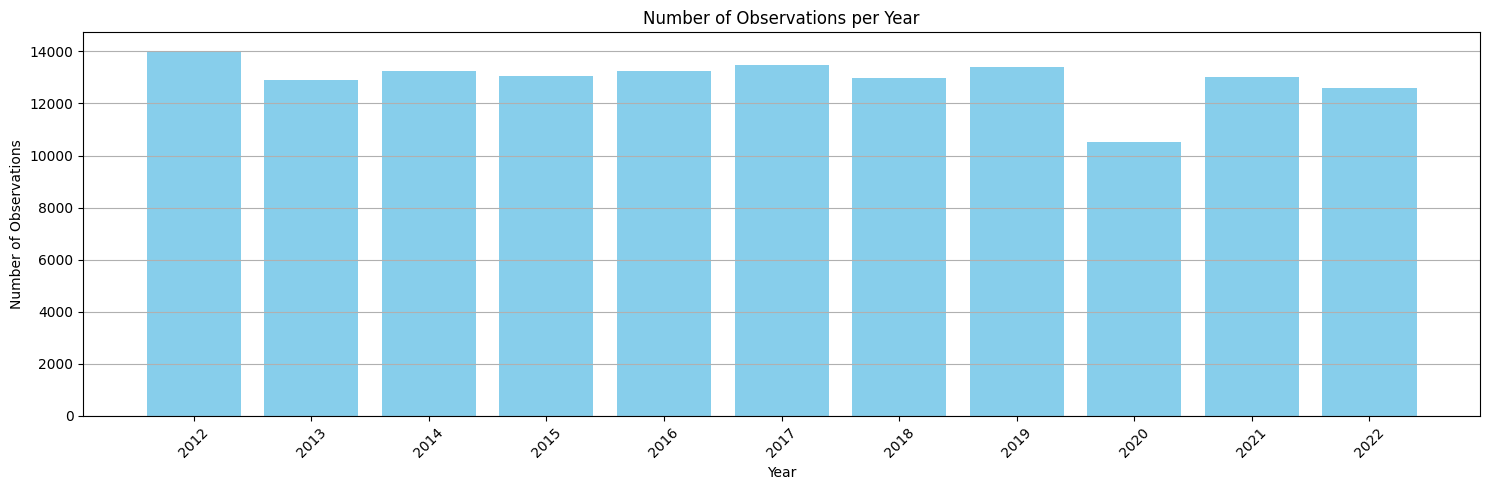

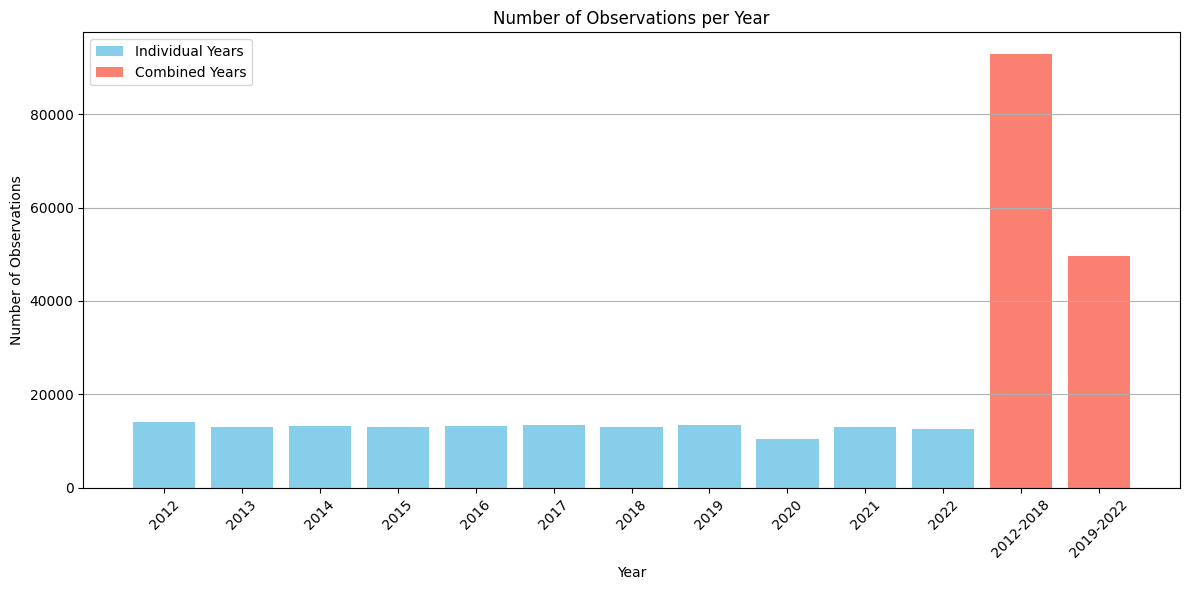

In [4]:
test_data.name = 'test_data'
process_data_and_plot(test_data)

# Répartition 2012 à 2022 sur le TRAIN Set

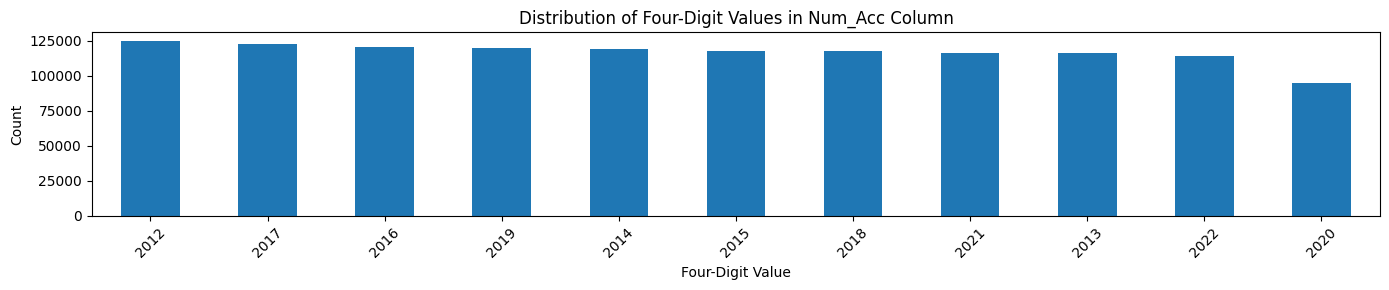

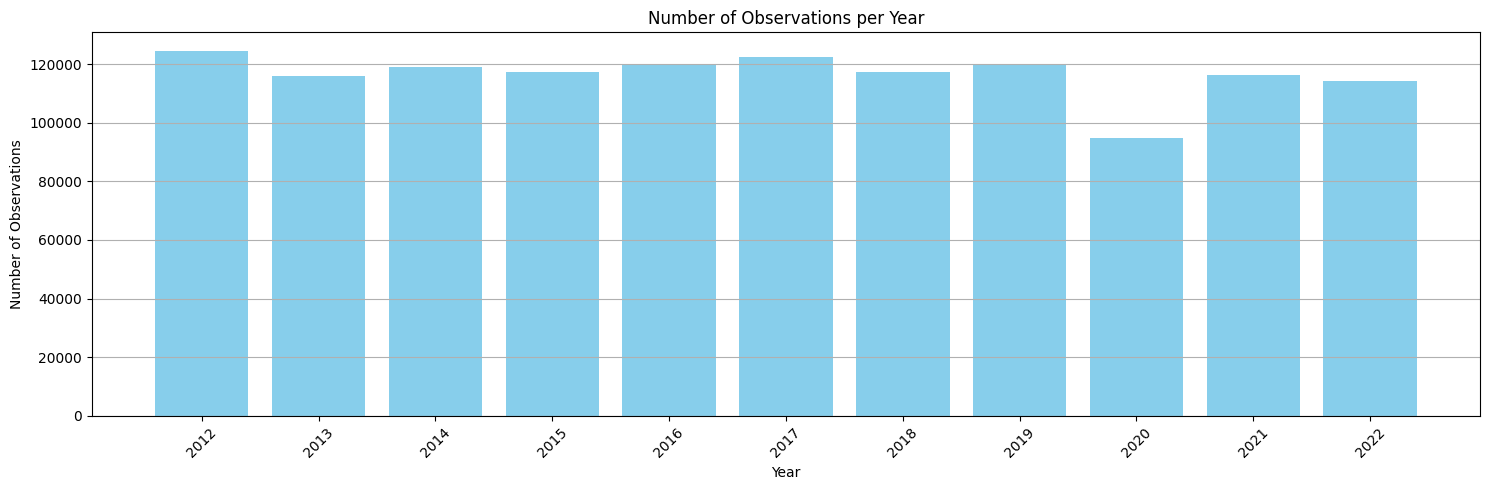

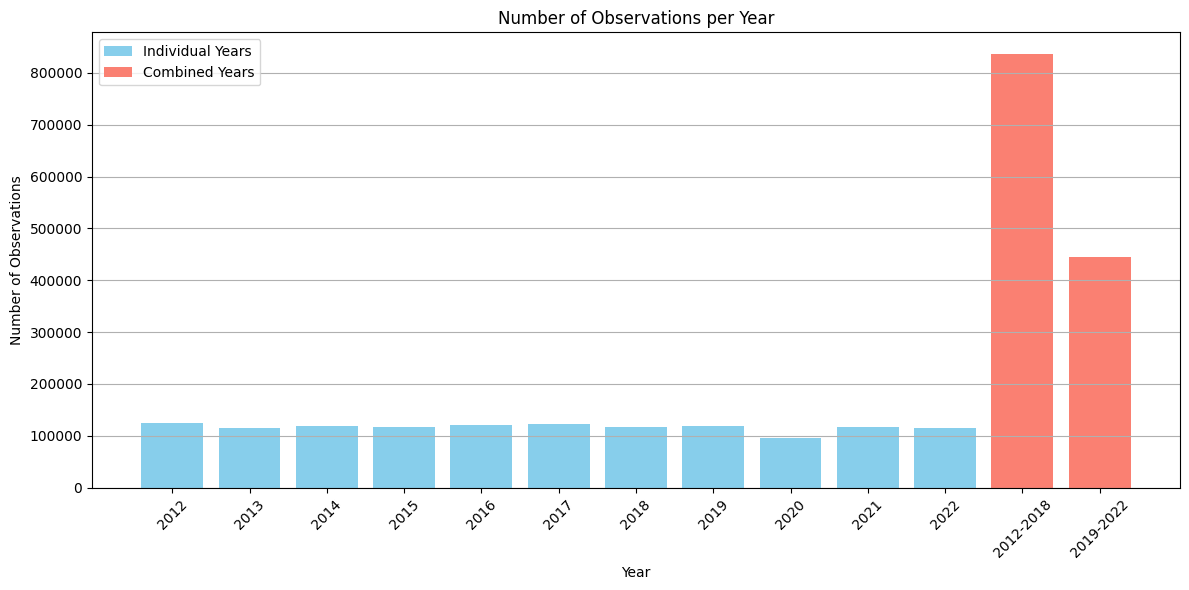

In [5]:
train_data.name = 'train_data'
process_data_and_plot(train_data)

On observe que les deux jeux de données au complet comportent globalement une répartition similaire des observations par an avec un facteur multiplicatif 'λ' (~10).

# Data 2012 - 2018 vs Data 2019 - 2022

### 2012 - 2018

In [6]:
display_info(test_data_2012_2018, train_data_2012_2018)

*******
TEST
- id_vehicule_x: 100.00%.
TRAIN
- id_vehicule_x: 100.00%.

*******
TEST
- secu1: 100.00%.
TRAIN
- secu1: 100.00%.

*******
TEST
- secu2: 100.00%.
TRAIN
- secu2: 100.00%.

*******
TEST
- secu3: 100.00%.
TRAIN
- secu3: 100.00%.

*******
TEST
- id_usager: 100.00%.
TRAIN
- id_usager: 100.00%.

*******
TEST
- id_vehicule_y: 100.00%.
TRAIN
- id_vehicule_y: 100.00%.

*******
TEST
- motor: 100.00%.
TRAIN
- motor: 100.00%.

*******
TEST
- vma: 100.00%.
TRAIN
- vma: 100.00%.

*******
TEST
- v1: 99.49%.
TRAIN
- v1: 99.48%.

*******
TEST
- v2: 96.43%.
TRAIN
- v2: 96.11%.

*******
TEST
- pr1: 49.84%.
TRAIN
- pr1: 49.92%.

*******
TEST
- pr: 49.54%.
TRAIN
- pr: 49.61%.

*******
TEST
- lat: 32.66%.
TRAIN
- lat: 32.32%.

*******
TEST
- long: 32.66%.
TRAIN
- long: 32.33%.

*******
TEST
- gps: 30.66%.
TRAIN
- gps: 30.34%.

*******
TEST
- voie: 14.43%.
TRAIN
- voie: 14.12%.

*******
TEST
- lartpc: 13.28%.
TRAIN
- lartpc: 13.32%.

*******
TEST
- larrout: 13.03%.
TRAIN
- larrout: 12.95%.

****

Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **id_vehicule_x** : 100.00% de valeurs manquantes.
- **id_vehicule_y** : 100.00% de valeurs manquantes.
- **id_usager** : 100.00% de valeurs manquantes.
- **motor** : 100.00% de valeurs manquantes.
- **secu1** : 100.00% de valeurs manquantes.
- **secu2** : 100.00% de valeurs manquantes.
- **secu3** : 100.00% de valeurs manquantes.
- **long** : 32.66% de valeurs manquantes.
- **lat** : 32.66% de valeurs manquantes.
- **pr1** : 49.84% de valeurs manquantes.
- **vma** : 100.0% de valeurs manquantes.
- **gps** : 30.66% de valeurs manquantes.
- **pr** : 49.54% de valeurs manquantes.
- **v1** : 99.49% de valeurs manquantes.
- **v2** : 96.43% de valeurs manquantes.

On notera que la répartition du jeu de données pour l'entraînement et pour le test sont sensiblement les mêmes.

In [7]:
col_to_drop_2012_2018 = ['id_vehicule_x', 'id_vehicule_y', 'id_usager', 'secu1', 'secu2', 'secu3', 'motor', 'vma', 'v1', 'v2', 'pr1', 'pr','long', 'lat', 'gps']
col_to_drop_imperatively_2012_2018 = ['id_vehicule_x', 'id_vehicule_y', 'id_usager', 'secu1', 'secu2', 'secu3', 'motor', 'vma']
list_df = [test_data_2012, test_data_2013, test_data_2014, test_data_2015, test_data_2016, test_data_2017, test_data_2018, test_data_2012_2018, train_data_2012, train_data_2013, train_data_2014, train_data_2015, train_data_2016, train_data_2017, train_data_2018, train_data_2012_2018]

for df in list_df:
    df.drop(columns=col_to_drop_imperatively_2012_2018, inplace=True)

### 2019 - 2022

In [8]:
display_info(test_data_2019_2022, train_data_2019_2022)

*******
TEST
- secu: 100.00%.
TRAIN
- secu: 100.00%.

*******
TEST
- gps: 100.00%.
TRAIN
- gps: 100.00%.

*******
TEST
- env1: 100.00%.
TRAIN
- env1: 100.00%.

*******
TEST
- lartpc: 99.76%.
TRAIN
- lartpc: 99.78%.

*******
TEST
- occutc: 98.65%.
TRAIN
- occutc: 98.75%.

*******
TEST
- v2: 91.86%.
TRAIN
- v2: 92.01%.

*******
TEST
- id_usager: 48.29%.
TRAIN
- id_usager: 48.22%.

*******
TEST
- larrout: 26.89%.
TRAIN
- larrout: 26.74%.

*******
TEST
- voie: 9.72%.
TRAIN
- voie: 9.61%.

*******
TEST
- v1: 5.03%.
TRAIN
- v1: 4.97%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **id_usager** : 48.29% de valeurs manquantes.
- **lartpc** : 99.76% de valeurs manquantes.
- **occutc** : 98.65% de valeurs manquantes.
- **secu** : 100.00% de valeurs manquantes.
- **env1** : 100.00% de valeurs manquantes.
- **gps** : 100.00% de valeurs manquantes.
- **v2** : 91.86% de valeurs manquantes.

In [9]:
col_to_drop_2019_2022 = ['id_usager', 'secu', 'lartpc', 'occutc', 'env1', 'gps', 'v2']
col_to_drop_imperatively_2019_2022 = ['secu', 'env1', 'gps']
list_df = [test_data_2019,test_data_2020, test_data_2021, test_data_2022, test_data_2019_2022, train_data_2019,train_data_2020 , train_data_2022, train_data_2019_2022]

for df in list_df:
    df.drop(columns=col_to_drop_imperatively_2019_2022, inplace=True)

### 2012

In [10]:
display_info(test_data_2012, train_data_2012)

*******
TEST
- v1: 99.49%.
TRAIN
- v1: 99.59%.

*******
TEST
- v2: 95.92%.
TRAIN
- v2: 95.73%.

*******
TEST
- lat: 54.95%.
TRAIN
- lat: 53.81%.

*******
TEST
- long: 54.95%.
TRAIN
- long: 53.81%.

*******
TEST
- gps: 52.82%.
TRAIN
- gps: 51.55%.

*******
TEST
- pr1: 52.30%.
TRAIN
- pr1: 52.18%.

*******
TEST
- pr: 52.10%.
TRAIN
- pr: 51.91%.

*******
TEST
- adr: 16.48%.
TRAIN
- adr: 17.45%.

*******
TEST
- voie: 10.41%.
TRAIN
- voie: 10.84%.

*******
TEST
- place: 8.51%.
TRAIN
- place: 8.97%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **long** : 54.95% de valeurs manquantes.
- **lat** : 54.95% de valeurs manquantes.
- **gps** : 52.82% de valeurs manquantes.
- **pr1** : 52.30% de valeurs manquantes.
- **pr** : 52.10% de valeurs manquantes.
- **v1** : 99.49% de valeurs manquantes.
- **v2** : 91.86% de valeurs manquantes.

In [11]:
col_to_drop_2012 = ['v1', 'v2', 'pr', 'pr1', 'gps', 'lat', 'long']

test_data_filtered_2012 = test_data_2012.drop(columns=col_to_drop_2012, inplace=False)
train_data_filtered_2012 = train_data_2012.drop(columns=col_to_drop_2012, inplace=False)

### 2013

In [12]:
display_info(test_data_2013, train_data_2013)

*******
TEST
- v1: 99.61%.
TRAIN
- v1: 99.61%.

*******
TEST
- v2: 96.78%.
TRAIN
- v2: 96.88%.

*******
TEST
- pr1: 52.48%.
TRAIN
- pr1: 52.69%.

*******
TEST
- pr: 52.24%.
TRAIN
- pr: 52.30%.

*******
TEST
- lat: 49.74%.
TRAIN
- lat: 50.77%.

*******
TEST
- long: 49.74%.
TRAIN
- long: 50.77%.

*******
TEST
- gps: 49.31%.
TRAIN
- gps: 50.32%.

*******
TEST
- adr: 17.80%.
TRAIN
- adr: 17.29%.

*******
TEST
- place: 9.14%.
TRAIN
- place: 9.38%.

*******
TEST
- voie: 7.76%.
TRAIN
- voie: 7.57%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **long** : 49.74% de valeurs manquantes.
- **lat** : 49.74% de valeurs manquantes.
- **gps** : 49.31% de valeurs manquantes.
- **pr1** : 52.48% de valeurs manquantes.
- **pr** : 52.24% de valeurs manquantes.
- **v1** : 99.61% de valeurs manquantes.
- **v2** : 96.78% de valeurs manquantes.

In [13]:
col_to_drop_2013 = ['v1', 'v2', 'pr', 'pr1', 'gps', 'lat', 'long']

test_data_filtered_2013 = test_data_2013.drop(columns=col_to_drop_2013, inplace=False)
train_data_filtered_2013 = train_data_2013.drop(columns=col_to_drop_2013, inplace=False)

### 2014

In [14]:
display_info(test_data_2014, train_data_2014)

*******
TEST
- v1: 99.47%.
TRAIN
- v1: 99.58%.

*******
TEST
- v2: 97.12%.
TRAIN
- v2: 96.70%.

*******
TEST
- pr1: 52.44%.
TRAIN
- pr1: 52.66%.

*******
TEST
- pr: 51.95%.
TRAIN
- pr: 52.35%.

*******
TEST
- lat: 46.81%.
TRAIN
- lat: 47.97%.

*******
TEST
- long: 46.81%.
TRAIN
- long: 47.97%.

*******
TEST
- gps: 46.20%.
TRAIN
- gps: 47.37%.

*******
TEST
- adr: 17.61%.
TRAIN
- adr: 17.06%.

*******
TEST
- place: 9.38%.
TRAIN
- place: 9.29%.

*******
TEST
- voie: 6.44%.
TRAIN
- voie: 6.24%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **long** : 46.81% de valeurs manquantes.
- **lat** : 46.81% de valeurs manquantes.
- **gps** : 46.20% de valeurs manquantes.
- **pr1** : 52.44% de valeurs manquantes.
- **pr** : 51.95% de valeurs manquantes.
- **v1** : 99.47% de valeurs manquantes.
- **v2** : 97.12% de valeurs manquantes.

In [15]:
col_to_drop_2014 = ['v1', 'v2', 'pr', 'pr1', 'gps', 'lat', 'long']

test_data_filtered_2014 = test_data_2014.drop(columns=col_to_drop_2014, inplace=False)
train_data_filtered_2014 = train_data_2014.drop(columns=col_to_drop_2014, inplace=False)

### 2015

In [16]:
display_info(test_data_2015, train_data_2015)

*******
TEST
- v1: 99.37%.
TRAIN
- v1: 99.26%.

*******
TEST
- v2: 96.49%.
TRAIN
- v2: 96.56%.

*******
TEST
- pr1: 55.54%.
TRAIN
- pr1: 55.63%.

*******
TEST
- pr: 55.17%.
TRAIN
- pr: 55.32%.

*******
TEST
- lat: 36.60%.
TRAIN
- lat: 35.72%.

*******
TEST
- long: 36.60%.
TRAIN
- long: 35.72%.

*******
TEST
- gps: 36.09%.
TRAIN
- gps: 35.16%.

*******
TEST
- adr: 16.49%.
TRAIN
- adr: 16.88%.

*******
TEST
- place: 8.91%.
TRAIN
- place: 9.15%.

*******
TEST
- voie: 7.48%.
TRAIN
- voie: 7.52%.

*******
TEST
- secu: 5.77%.
TRAIN
- secu: 6.29%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **long** : 36.60% de valeurs manquantes.
- **lat** : 36.60% de valeurs manquantes.
- **gps** : 36.09% de valeurs manquantes.
- **pr1** : 55.54% de valeurs manquantes.
- **pr** : 55.17% de valeurs manquantes.
- **v1** : 99.37% de valeurs manquantes.
- **v2** : 96.49% de valeurs manquantes.

In [17]:
col_to_drop_2015 = ['v1', 'v2', 'pr', 'pr1', 'gps', 'lat', 'long']

test_data_filtered_2015 = test_data_2015.drop(columns=col_to_drop_2015, inplace=False)
train_data_filtered_2015 = train_data_2015.drop(columns=col_to_drop_2015, inplace=False)

### 2016

In [18]:
display_info(test_data_2016, train_data_2016)

*******
TEST
- v1: 99.41%.
TRAIN
- v1: 99.24%.

*******
TEST
- v2: 96.19%.
TRAIN
- v2: 96.40%.

*******
TEST
- pr: 56.13%.
TRAIN
- pr: 55.30%.

*******
TEST
- pr1: 56.02%.
TRAIN
- pr1: 55.37%.

*******
TEST
- lat: 22.48%.
TRAIN
- lat: 21.43%.

*******
TEST
- long: 22.48%.
TRAIN
- long: 21.43%.

*******
TEST
- gps: 21.46%.
TRAIN
- gps: 20.37%.

*******
TEST
- voie: 17.10%.
TRAIN
- voie: 16.40%.

*******
TEST
- adr: 15.65%.
TRAIN
- adr: 16.39%.

*******
TEST
- place: 8.59%.
TRAIN
- place: 8.90%.

*******
TEST
- secu: 6.73%.
TRAIN
- secu: 7.05%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **long** : 22.48% de valeurs manquantes.
- **lat** : 22.48% de valeurs manquantes.
- **pr1** : 56.02% de valeurs manquantes.
- **pr** : 52.10% de valeurs manquantes.
- **v1** : 99.41% de valeurs manquantes.
- **v2** : 96.19% de valeurs manquantes.

In [19]:
col_to_drop_2016 = ['v1', 'v2', 'pr', 'pr1', 'lat', 'long']

test_data_filtered_2016 = test_data_2016.drop(columns=col_to_drop_2016, inplace=False)
train_data_filtered_2016 = train_data_2016.drop(columns=col_to_drop_2016, inplace=False)

### 2017

In [20]:
display_info(test_data_2017, train_data_2017)

*******
TEST
- v1: 99.34%.
TRAIN
- v1: 99.36%.

*******
TEST
- v2: 96.24%.
TRAIN
- v2: 95.21%.

*******
TEST
- pr1: 54.82%.
TRAIN
- pr1: 54.17%.

*******
TEST
- pr: 54.40%.
TRAIN
- pr: 53.81%.

*******
TEST
- voie: 15.78%.
TRAIN
- voie: 14.83%.

*******
TEST
- lat: 13.76%.
TRAIN
- lat: 13.20%.

*******
TEST
- long: 13.76%.
TRAIN
- long: 13.20%.

*******
TEST
- place: 8.78%.
TRAIN
- place: 8.67%.

*******
TEST
- gps: 7.66%.
TRAIN
- gps: 7.48%.

*******
TEST
- secu: 6.72%.
TRAIN
- secu: 6.56%.

*******
TEST
- infra: 6.33%.
TRAIN
- infra: 6.34%.

*******
TEST
- env1: 6.27%.
TRAIN
- env1: 6.45%.

*******
TEST
- situ: 6.01%.
TRAIN
- situ: 6.03%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **pr1** : 54.82% de valeurs manquantes.
- **pr** : 54.40% de valeurs manquantes.
- **v1** : 99.34% de valeurs manquantes.
- **v2** : 96.24% de valeurs manquantes.

In [21]:
col_to_drop_2017 = ['v1', 'v2', 'pr', 'pr1']

test_data_filtered_2017 = test_data_2017.drop(columns=col_to_drop_2017, inplace=False)
train_data_filtered_2017 = train_data_2017.drop(columns=col_to_drop_2017, inplace=False)

### 2018

In [22]:
display_info(test_data_2018, train_data_2018)

*******
TEST
- v1: 99.71%.
TRAIN
- v1: 99.73%.

*******
TEST
- v2: 96.35%.
TRAIN
- v2: 95.33%.

*******
TEST
- lartpc: 78.40%.
TRAIN
- lartpc: 77.89%.

*******
TEST
- larrout: 77.96%.
TRAIN
- larrout: 77.13%.

*******
TEST
- locp: 43.34%.
TRAIN
- locp: 41.83%.

*******
TEST
- etatp: 43.34%.
TRAIN
- etatp: 41.83%.

*******
TEST
- actp: 43.34%.
TRAIN
- actp: 41.83%.

*******
TEST
- voie: 36.47%.
TRAIN
- voie: 35.58%.

*******
TEST
- pr1: 24.65%.
TRAIN
- pr1: 26.26%.

*******
TEST
- pr: 24.21%.
TRAIN
- pr: 25.79%.

*******
TEST
- place: 8.73%.
TRAIN
- place: 8.39%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **lartpc** : 78.40% de valeurs manquantes.
- **larrout** : 77.96% de valeurs manquantes.
- **locp** : 43.34% de valeurs manquantes.
- **etatp** : 43.34% de valeurs manquantes. 
- **actp** : 43.34% de valeurs manquantes. 
- **voie** : 36.47% de valeurs manquantes. 
- **v1** : 99.71% de valeurs manquantes.
- **v2** : 96.35% de valeurs manquantes.

In [23]:
col_to_drop_2018 = ['v1', 'v2', 'voie', 'actp', 'etatp', 'locp', 'larrout', 'lartpc']

test_data_filtered_2018 = test_data_2018.drop(columns=col_to_drop_2018, inplace=False)
train_data_filtered_2018 = train_data_2018.drop(columns=col_to_drop_2018, inplace=False)

### 2019

In [24]:
display_info(test_data_2019, train_data_2019)

*******
TEST
- id_usager: 100.00%.
TRAIN
- id_usager: 100.00%.

*******
TEST
- lartpc: 99.55%.
TRAIN
- lartpc: 99.66%.

*******
TEST
- larrout: 99.29%.
TRAIN
- larrout: 99.38%.

*******
TEST
- occutc: 98.55%.
TRAIN
- occutc: 98.59%.

*******
TEST
- v2: 92.75%.
TRAIN
- v2: 92.66%.

*******
TEST
- v1: 18.59%.
TRAIN
- v1: 18.49%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **id_usager** : 100.00% de valeurs manquantes.
- **lartpc** : 99.55% de valeurs manquantes.
- **larrout** : 99.29% de valeurs manquantes.
- **occutc** : 98.55% de valeurs manquantes.
- **v2** : 92.75% de valeurs manquantes.

In [25]:
col_to_drop_2019 = ['id_usager', 'lartpc', 'larrout', 'occutc', 'v2']

test_data_filtered_2019 = test_data_2019.drop(columns=col_to_drop_2019, inplace=False)
train_data_filtered_2019 = train_data_2019.drop(columns=col_to_drop_2019, inplace=False)

### 2020

In [26]:
display_info(test_data_2020, train_data_2020)

*******
TEST
- id_usager: 100.00%.
TRAIN
- id_usager: 100.00%.

*******
TEST
- lartpc: 99.81%.
TRAIN
- lartpc: 99.70%.

*******
TEST
- occutc: 98.87%.
TRAIN
- occutc: 98.88%.

*******
TEST
- v2: 93.85%.
TRAIN
- v2: 93.69%.

*******
TEST
- voie: 21.78%.
TRAIN
- voie: 21.38%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **id_usager** : 100.00% de valeurs manquantes.
- **lartpc** : 99.81% de valeurs manquantes.
- **occutc** : 98.87% de valeurs manquantes.
- **v2** : 93.85% de valeurs manquantes.

In [27]:
col_to_drop_2020 = ['id_usager', 'lartpc', 'occutc', 'v2']

test_data_filtered_2020 = test_data_2020.drop(columns=col_to_drop_2020, inplace=False)
train_data_filtered_2020 = train_data_2020.drop(columns=col_to_drop_2020, inplace=False)

### 2021

In [28]:
display_info(test_data_2021, train_data_2021)

*******
TEST
- lartpc: 99.80%.
TRAIN
- lartpc: 99.81%.

*******
TEST
- occutc: 98.84%.
TRAIN
- occutc: 98.94%.

*******
TEST
- v2: 90.47%.
TRAIN
- v2: 91.36%.

*******
TEST
- voie: 6.99%.
TRAIN
- voie: 7.14%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **lartpc** : 99.80% de valeurs manquantes.
- **occutc** : 98.84% de valeurs manquantes.
- **v2** : 90.47% de valeurs manquantes.

In [29]:
col_to_drop_2021 = ['id_usager', 'lartpc', 'occutc', 'v2']

test_data_filtered_2021 = test_data_2021.drop(columns=col_to_drop_2021, inplace=False)
train_data_filtered_2021 = train_data_2021.drop(columns=col_to_drop_2021, inplace=False)

### 2022

In [30]:
display_info(test_data_2022, train_data_2022)

*******
TEST
- lartpc: 99.91%.
TRAIN
- lartpc: 99.95%.

*******
TEST
- occutc: 98.38%.
TRAIN
- occutc: 98.63%.

*******
TEST
- v2: 90.71%.
TRAIN
- v2: 90.60%.

*******
TEST
- voie: 8.06%.
TRAIN
- voie: 7.78%.


Les features qui contiennent trop peu de variables et qui malgré une imputation ne saurait être pertinente, car l'imputation biaiserait les données sont :
- **lartpc** : 99.91% de valeurs manquantes.
- **occutc** : 98.38% de valeurs manquantes.
- **v2** : 90.71% de valeurs manquantes.

In [31]:
col_to_drop_2022 = ['lartpc', 'occutc', 'v2']

test_data_filtered_2022 = test_data_2022.drop(columns=col_to_drop_2022, inplace=False)
train_data_filtered_2022 = train_data_2022.drop(columns=col_to_drop_2022, inplace=False)

# Disparité en fonction des années

On observe si des colonnes sont présentes ou absentes en fonction des années. En fonction, il est possible de décliner un modèle pour plusieurs modèles afin d'exploiter aux mieux les données. Si dans certaines années la variable 'lartpc' est inexploitable par manque d'éléments, il se peut que dans d'autres années cette dernière soit exploitable. Ainsi, des clusters doivent être construits pour ensuite réaliser le feature engineering de chaque cluster.

Afin de réaliser ce clustering, on peut souligner que les dataframes des train/test sets sont liés par un même traitement. Ainsi, il suffit de trouver parmi les dataframes de test les clusters.

In [32]:
from collections import defaultdict

list_all_test_df = [test_data_filtered_2012, test_data_filtered_2013, test_data_filtered_2014, test_data_filtered_2015, test_data_filtered_2016, 
    test_data_filtered_2017, test_data_filtered_2018, test_data_filtered_2019, test_data_filtered_2020, test_data_filtered_2021, test_data_filtered_2022, test_data_2012_2018, test_data_2019_2022]

list_all_test_df_names = [
    "test_data_filtered_2012", "test_data_filtered_2013", "test_data_filtered_2014", "test_data_filtered_2015", "test_data_filtered_2016", "test_data_filtered_2017",
    "test_data_filtered_2018", "test_data_filtered_2019", "test_data_filtered_2020", "test_data_filtered_2021", "test_data_filtered_2022", "test_data_2012_2018",
    "test_data_2019_2022"]

clustered_dataframes = defaultdict(list)

for df_name, df in zip(list_all_test_df_names, list_all_test_df):
    columns_key = frozenset(df.columns)
    clustered_dataframes[columns_key].append(df_name)

list_clusters = list(clustered_dataframes.values())

for i, cluster in enumerate(list_clusters, 1):
    print(f"Cluster {i}: {cluster}")

Cluster 1: ['test_data_filtered_2012', 'test_data_filtered_2013', 'test_data_filtered_2014', 'test_data_filtered_2015']
Cluster 2: ['test_data_filtered_2016']
Cluster 3: ['test_data_filtered_2017']
Cluster 4: ['test_data_filtered_2018']
Cluster 5: ['test_data_filtered_2019']
Cluster 6: ['test_data_filtered_2020', 'test_data_filtered_2021']
Cluster 7: ['test_data_filtered_2022']
Cluster 8: ['test_data_2012_2018']
Cluster 9: ['test_data_2019_2022']


Ainsi, on observe les clusters suivants :
- **2012/2013/2014/2015** : 44 variables.
- **2020/2021** : 52 variables.
- **2016** : 45 variables.
- **2017** : 47 variables.
- **2018** : 43 variables.
- **2019** : 51 variables.
- **2022** : 53 variables.
- **2012 à 2018** : 51 variables.
- **2019 à 2022** : 56 variables.

On décide de stocker individuellement tous les jeux de données par an (test_data_filtered_2012/train_data_filtered_2012, ...). On testera de construire un modèle par an étant donné que les deux jeux de données sont proportionnés équitablement. Dans un second temps, on sauvegarde des clusters de données, ainsi, il sera possible d'observer si la généralisation des données permettra une réduction de l'overfitting et une amélioration des performances, ou bien une réduction de la généralisation et une croissance de l'overfitting.

In [33]:
for year in range(2012, 2023):
    test_data_var_name = f"test_data_filtered_{year}"
    train_data_var_name = f"train_data_filtered_{year}"
    
    if test_data_var_name in globals():
        test_data = globals()[test_data_var_name]
        test_data.to_csv(f"Filtered_Data/TEST/DRAFT/{test_data_var_name}.csv", index=False)
        
    if train_data_var_name in globals():
        train_data = globals()[train_data_var_name]
        train_data.to_csv(f"Filtered_Data/TRAIN/DRAFT/{train_data_var_name}.csv", index=False)

In [35]:
# TRAIN 2012/2013/2014/2015
concatenated_df = pd.concat([train_data_filtered_2012, train_data_filtered_2013, train_data_filtered_2014, train_data_filtered_2015], ignore_index=True)
concatenated_df.to_csv("Filtered_Data/TRAIN/DRAFT/train_data_filtered_2012_13_14_15.csv", index=False)

# TRAIN 2020/2021
concatenated_df = pd.concat([train_data_filtered_2020, train_data_filtered_2021], ignore_index=True)
concatenated_df.to_csv("Filtered_Data/TRAIN/DRAFT/train_data_filtered_2020_21.csv", index=False)

# TRAIN 2012-2018 & 2019-2022
train_data_2012_2018.to_csv("Filtered_Data/TRAIN/DRAFT/train_data_filtered_2012_2018.csv", index=False)
train_data_2019_2022.to_csv("Filtered_Data/TRAIN/DRAFT/train_data_filtered_2019_2022.csv", index=False)

# TEST 2012/2013/2014/2015
concatenated_df = pd.concat([test_data_filtered_2012, test_data_filtered_2013, test_data_filtered_2014, test_data_filtered_2015], ignore_index=True)
concatenated_df.to_csv("Filtered_Data/TEST/DRAFT/test_data_filtered_2012_13_14_15.csv", index=False)

# TEST 2020/2021
concatenated_df = pd.concat([test_data_filtered_2020, test_data_filtered_2021], ignore_index=True)
concatenated_df.to_csv("Filtered_Data/TEST/DRAFT/test_data_filtered_2020_21.csv", index=False)

# TEST 2012-2018 & 2019-2022
test_data_2012_2018.to_csv("Filtered_Data/TEST/DRAFT/test_data_filtered_2012_2018.csv", index=False)
test_data_2019_2022.to_csv("Filtered_Data/TEST/DRAFT/test_data_filtered_2019_2022.csv", index=False)